This is the work for reproducing Alphafold 1 using pytorch and Signatory path reconstruction. This work is done for Oxford Summer Project, under supervision of Dr.Cris Salvi. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/alphafold_pytorch/alphafold_pytorch-29bd20b0ca0ccd31d984a7dc53f0302d945a2ddc/")

In [ ]:
!pip install signatory
!pip install Biopython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import signatory
from Bio.PDB import *
import torch
import torch.nn.functional as nnf
import torchvision.transforms.functional as F
import tqdm

Now, we read in the given pdb file, and try to calculate it's backbone path as signature. Then we want to reverse the given signature and re-construct the whole thing.


In [ ]:
pdb_file = "T1019s2.pdb"

In [ ]:
parser = PDBParser()
structure = parser.get_structure("MyProtein", pdb_file)

In [ ]:
# Grab the central backbone to the list
Backbone = [] #So we only consider the path for  
for chains in structure:
  for chain in chains:
      for residue in chain:
          Backbone += [list(residue[x].get_vector()) for x in ['N','CA','C']]                        

In [ ]:
this_path = torch.tensor(Backbone)

Calculate the Signature of our path as a whole

In [ ]:
depth = 10
path = this_path.unsqueeze(0)

In [ ]:
sig = signatory.signature(path, depth)

Now, given our signature, we try to invert the signature to create the path

In [ ]:
# Reconstruct the path by inverting the signature
reconstructed_path = signatory.invert_signature(sig, depth, path.shape[2], initial_position=path[:, 0, :])

We try to plot the 3d graph for this:

In [ ]:
import matplotlib.pyplot as plt
#  %matplotlib notebook
# Remove the above comment line to activate interactive plot. Not supported in Colab
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
my_first_path = np.array(path)[0]
my_first_predict_path = np.array(reconstructed_path)[0]

In [ ]:
print(np.shape(my_first_path))
print(np.shape(my_first_predict_path))

(264, 3)
(11, 3)


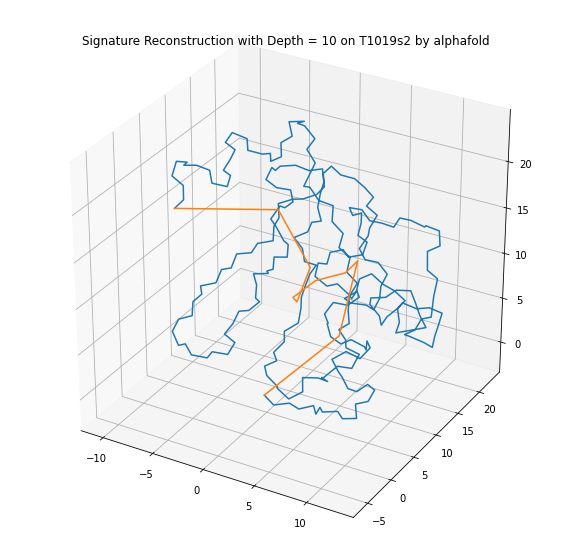

In [ ]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection='3d')

x1,y1,z1 = np.transpose(my_first_path)
x2,y2,z2 = np.transpose(my_first_predict_path)

ax.plot(x1,y1,z1,label = "Original")
ax.plot(x2,y2,z2,label = "Reconstruct")
ax.set_title("Signature Reconstruction with Depth = 10 on T1019s2 by alphafold")
#plt.savefig("Reconstruct.png")
plt.show()


Observe that this reconstruction only capture a vague idea on how the protein fold, but it is not accurate at all.
<br><br>
The main reason we cannot create that much of the point is because of the complexity in **invert_signature** function call. A depth >15 is already computationally expensive, leave alone the whole sequence of 264.
<br><br>
A natural way is to split up and reconstruct the progress using a window size of 10

In [ ]:
DEPTH = 10
WINDOW = DEPTH
DIM = path.shape[2]
path_class = signatory.Path(path, DEPTH)

In [ ]:
length= path_class.shape[1]
print(length)

264


In [ ]:
def divisible(large,small):
  # return 1 if small is divisible by large
  return large%small == 0

In [ ]:
sig_list = [] # store all the piece_wise signature
for index in range(int(length/WINDOW)+1- divisible(length,WINDOW)):
  start_index = index*WINDOW
  end_index = min(length-1,(index + 1) * WINDOW)
  sig = path_class.signature(start_index,end_index+1)
  sig_list.append({"start":start_index, "end":end_index, "sig":sig})

Now this is a new reconstruction process

First we split the path into several segment(subpath) with the same window_size (10). Then we try to invert each of the segment using the previously stored signature on that segment, and concatenate all the segment together to form the signature.
<br><br>
Note here that we ensure the continuity of the reconstructed path by passing in **initial_position argument** to the **invert_signature** function.  

In [ ]:
def resampling(recon_subpath,DEPTH, size):
  # where we inverse DEPTH+1 number of points, but there are only size+1 number of atoms
  index = np.linspace(0, DEPTH, num=size+1, endpoint=True, retstep=False, dtype= int, axis=0)
  my_list = []
  for i,value in enumerate(recon_subpath[0]):
    if i in index:
      my_list.append(value)
  out = torch.stack(my_list).unsqueeze(0)
  #out = torch.stack([value if i in index for i, value in enumerate(recon_subpath) ]) 
  return out

In [ ]:
last_pos = torch.tensor(my_first_path[0]) # start at the same position as the original one
all_recon_subpath = [[last_pos]]
for dictionary in sig_list:
  sig = dictionary["sig"]
  size = dictionary["end"] - dictionary["start"]
  # some padding issue need to be resolve. The final 4 cannot be created in this way
  recon_subpath = signatory.invert_signature(sig, DEPTH, DIM, initial_position=last_pos)
  recon_subpath = list(recon_subpath)[0]
  last_pos = torch.tensor(recon_subpath[-1]) # update the position 
  if size == DEPTH:
    # so the first multiple numbers of batch
    all_recon_subpath.append(np.array(recon_subpath)[1:])
    
  else:
    # the tructated batch, where we inverse DEPTH+1 number of points, but there are only size+1 number of atoms
    # we carry out the sampling to added on it. 
    resampled_subpath = resampling(recon_subpath.unsqueeze(0), DEPTH, size).squeeze(0)
    all_recon_subpath.append(np.array(resampled_subpath)[1:])
recon_path = np.array([list(item) for sent in all_recon_subpath  for item in sent])
print(len(recon_path))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


264


In [ ]:
# We make sure that 2 paths start at the same location
print(recon_path[0])
print(my_first_path[0])

[ 0.89200002  2.66100001 -0.049     ]
[ 0.89200002  2.66100001 -0.049     ]


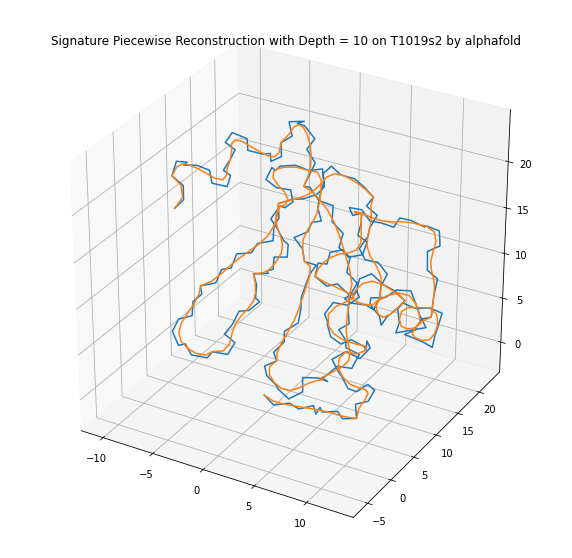

In [ ]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection='3d')

x1,y1,z1 = np.transpose(my_first_path)
x2,y2,z2 = np.transpose(recon_path)

ax.plot(x1,y1,z1,label = "Original")
ax.plot(x2,y2,z2,label = "Reconstruct_piecewise")
ax.set_title(f"Signature Piecewise Reconstruction with Depth = {DEPTH} on T1019s2 by alphafold")
plt.savefig("Reconstruct_piecewise_window=10.png")
plt.show()

Now we analyze the segment and see what are the loss function for each windows. 

In [ ]:
def linear_loss(predict_batch, gt_batch):
  # Input is the sampled points in the space, in piece-wise linear. 
  # Output is the loss function, which is the average euclidean distance between pair-wise value
  #print(np.shape(predict_batch),np.shape(gt_batch))
  assert np.shape(predict_batch) == np.shape(gt_batch)
  batch_num, points_num, DIM = np.shape(predict_batch)
  all_loss = []
  for index in range(batch_num):
    subVec = torch.sub(predict_batch[index], gt_batch[index])
    all_loss.append(torch.tensor(np.linalg.norm(subVec)/(points_num-1)))
  return torch.stack(all_loss)

In [ ]:
def fill_zeros(sig,template):
  # we want to fill sig into template if the shape doesn't match
  sig = np.array(sig)
  sig.resize(np.shape(template),refcheck=False)
  return sig

In [ ]:
# The following is the reconstruction loss for 3D coordinates, provided that the first one match
sig_stats_dict = []
for dictionary in tqdm.tqdm(sig_list):
  sig = dictionary["sig"]
  initial_index = dictionary["start"]
  final_index = dictionary["end"]
  size = final_index - initial_index
  gt_initial_pos = path[0][initial_index]
  
  recon_subpath = signatory.invert_signature(sig, DEPTH, DIM, initial_position=gt_initial_pos)
  if size != DEPTH:
      recon_subpath = resampling(recon_subpath, DEPTH, size)
  gt_path = path[:, initial_index:final_index+1, :]
  coord_loss = linear_loss(recon_subpath,gt_path)[0]
  sig_stats_dict.append(
      {
      "start":initial_index,
      "end":final_index,
      "recon_subpath":recon_subpath,
      "gt_path":gt_path,
      "coord_loss":coord_loss,
      }
  )

100%|██████████| 27/27 [00:00<00:00, 29.10it/s]


Now print out the bar chart for coord_loss and sig_loss

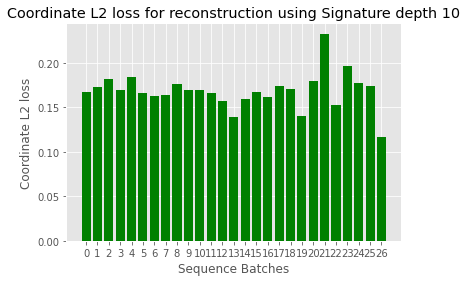

total_loss:  4.546626859632077


In [ ]:
plt.style.use('ggplot')

coord_loss = [item["coord_loss"] for item in sig_stats_dict]
total_loss = np.sum(coord_loss)
x_pos = [i for i, _ in enumerate(sig_stats_dict)]
x = x_pos
plt.bar(x_pos, coord_loss, color='green')
plt.xlabel("Sequence Batches")
plt.ylabel("Coordinate L2 loss")
plt.title(f"Coordinate L2 loss for reconstruction using Signature depth {DEPTH}")

plt.xticks(x_pos, x)
plt.savefig("Coordinates_loss.png")
plt.show()
print("total_loss: ",total_loss)

Now we run an automatic script, to try from DEPTH = 3 to 12, and plot the corrosponding loss for all.


In [ ]:
x = [i for i in range(3,13)]
y = []
for DEPTH in tqdm.tqdm(x):
  WINDOW = DEPTH
  DIM = path.shape[2]
  path_class = signatory.Path(path, DEPTH)
  sig_list = [] # store all the piece_wise signature
  for index in range(int(length/WINDOW)+1- divisible(length,WINDOW)):
    start_index = index*WINDOW
    end_index = min(length-1,(index + 1) * WINDOW)
    sig = path_class.signature(start_index,end_index+1)
    sig_list.append({"start":start_index, "end":end_index, "sig":sig})
  last_pos = torch.tensor(my_first_path[0]) # start at the same position as the original one
  all_recon_subpath = [[last_pos]]
  for dictionary in sig_list:
    sig = dictionary["sig"]
    size = dictionary["end"] - dictionary["start"]
    # some padding issue need to be resolve. The final 4 cannot be created in this way
    recon_subpath = signatory.invert_signature(sig, DEPTH, DIM, initial_position=last_pos)
    recon_subpath = list(recon_subpath)[0]
    last_pos = torch.tensor(recon_subpath[-1]) # update the position 
    if size == DEPTH:
      # so the first multiple numbers of batch
      all_recon_subpath.append(np.array(recon_subpath)[1:])
    else:
      # the tructated batch, where we inverse DEPTH+1 number of points, but there are only size+1 number of atoms
      # we carry out the sampling to added on it. 
      resampled_subpath = resampling(recon_subpath.unsqueeze(0), DEPTH, size).squeeze(0)
      all_recon_subpath.append(np.array(resampled_subpath)[1:])
  recon_path = np.array([list(item) for sent in all_recon_subpath  for item in sent])
  # The following is the reconstruction loss for 3D coordinates, provided that the first one match
  sig_stats_dict = []
  for dictionary in sig_list:
    sig = dictionary["sig"]
    initial_index = dictionary["start"]
    final_index = dictionary["end"]
    size = final_index - initial_index
    gt_initial_pos = path[0][initial_index]
    
    recon_subpath = signatory.invert_signature(sig, DEPTH, DIM, initial_position=gt_initial_pos)
    if size != DEPTH:
        recon_subpath = resampling(recon_subpath, DEPTH, size)
    gt_path = path[:, initial_index:final_index+1, :]
    coord_loss = linear_loss(recon_subpath,gt_path)[0]
    sig_stats_dict.append(coord_loss)
  y.append(np.sum(sig_stats_dict))

100%|██████████| 10/10 [00:35<00:00,  3.57s/it]


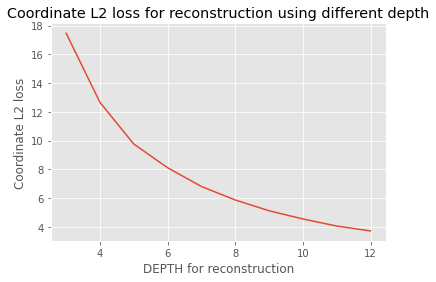

In [ ]:
plt.plot(x,y)
plt.xlabel("DEPTH for reconstruction")
plt.ylabel("Coordinate L2 loss")
plt.title(f"Coordinate L2 loss for reconstruction using different depth")

plt.savefig("Depth-loss relation.png")
plt.show()